In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news-detection/true.csv
/kaggle/input/fake-news-detection/fake.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score ,f1_score,recall_score,precision_score
from collections import defaultdict
import re
from datasets import concatenate_datasets, load_dataset
import matplotlib.pyplot as plt


In [ ]:
data_fake = pd.read_csv("/kaggle/input/fake-news-detection/fake.csv")
data_true = pd.read_csv("/kaggle/input/fake-news-detection/true.csv")

In [ ]:
data_fake ["lable"] =0
data_true ["lable"] =1

In [ ]:
def preprocess_text(text):
    text = text.lower()  # تبدیل به حروف کوچک
    text = re.sub(r'[^\w\s]', '', text)  # حذف علائم نگارشی
    text = re.sub(r'\d+', '', text)  # حذف اعداد
    return text

In [ ]:
data_fake['cleaned_text'] = data_fake['text'].apply(preprocess_text)

In [ ]:
data_true['cleaned_text'] = data_true['text'].apply(preprocess_text)

In [ ]:
dataset= pd.concat([data_fake, data_true], axis=0, ignore_index=True)

In [ ]:
dataset = dataset.drop('text', axis=1)

In [ ]:
dataset

,title,subject,date,lable,cleaned_text
0,Donald Trump Sends Out Embarrassing New Year’...,News,"December 31, 2017",0,donald trump just couldn t wish all americans ...
1,Drunk Bragging Trump Staffer Started Russian ...,News,"December 31, 2017",0,house intelligence committee chairman devin nu...
2,Sheriff David Clarke Becomes An Internet Joke...,News,"December 30, 2017",0,on friday it was revealed that former milwauke...
3,Trump Is So Obsessed He Even Has Obama’s Name...,News,"December 29, 2017",0,on christmas day donald trump announced that h...
4,Pope Francis Just Called Out Donald Trump Dur...,News,"December 25, 2017",0,pope francis used his annual christmas day mes...
...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,worldnews,"August 22, 2017",1,brussels reuters nato allies on tuesday welco...
44894,LexisNexis withdrew two products from Chinese ...,worldnews,"August 22, 2017",1,london reuters lexisnexis a provider of legal...
44895,Minsk cultural hub becomes haven from authorities,worldnews,"August 22, 2017",1,minsk reuters in the shadow of disused soviet...
44896,Vatican upbeat on possibility of Pope Francis ...,worldnews,"August 22, 2017",1,moscow reuters vatican secretary of state car...


In [ ]:
# 3. ساخت مدل مارکوف برای توالی کلمات
# تابع برای ساخت ماتریس انتقال
def build_markov_chain(texts):
    markov_chain = defaultdict(lambda: defaultdict(int))
    for text in texts:
        words = text.split()
        for i in range(len(words) - 1):
            current_word, next_word = words[i], words[i + 1]
            markov_chain[current_word][next_word] += 1
    return markov_chain

In [ ]:
markov_chain = build_markov_chain(dataset['cleaned_text'])

In [ ]:
# تابع محاسبه احتمال توالی کلمات برای یک توییت
def calculate_markov_probability(text, markov_chain):
    words = text.split()
    probability = 1.0
    for i in range(len(words) - 1):
        current_word, next_word = words[i], words[i + 1]
        current_count = sum(markov_chain[current_word].values())
        if current_count > 0:
            probability *= markov_chain[current_word][next_word] / current_count
        else:
            probability *= 0.01  # احتمال کوچک برای کلمات نایاب
    return probability

In [ ]:
# افزودن احتمال مارکوف به داده‌ها
dataset['markov_probability'] = dataset['cleaned_text'].apply(lambda x: calculate_markov_probability(x, markov_chain))

In [ ]:
dataset = dataset.drop(['date','subject','title'], axis=1)

In [ ]:
dataset

,lable,cleaned_text,markov_probability
0,0,donald trump just couldn t wish all americans ...,0.000000e+00
1,0,house intelligence committee chairman devin nu...,0.000000e+00
2,0,on friday it was revealed that former milwauke...,0.000000e+00
3,0,on christmas day donald trump announced that h...,0.000000e+00
4,0,pope francis used his annual christmas day mes...,0.000000e+00
...,...,...,...
44893,1,brussels reuters nato allies on tuesday welco...,0.000000e+00
44894,1,london reuters lexisnexis a provider of legal...,4.955523e-275
44895,1,minsk reuters in the shadow of disused soviet...,0.000000e+00
44896,1,moscow reuters vatican secretary of state car...,0.000000e+00


In [ ]:
# 4. استخراج ویژگی‌ها با TF-IDF
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf.fit_transform(dataset['cleaned_text'])

In [ ]:
# ترکیب ویژگی‌های TF-IDF و احتمال مارکوف
X = np.hstack((X_tfidf.toarray(), dataset['markov_probability'].values.reshape(-1, 1)))
y = dataset['lable']

In [ ]:
# 5. تقسیم داده‌ها به مجموعه آموزشی و آزمایشی
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
(y_train==0).sum()/y_train.shape[0], (y_train==1).sum()/y_train.shape[0]

(0.5215094819905817, 0.47849051800941833)

# **Randomforest**

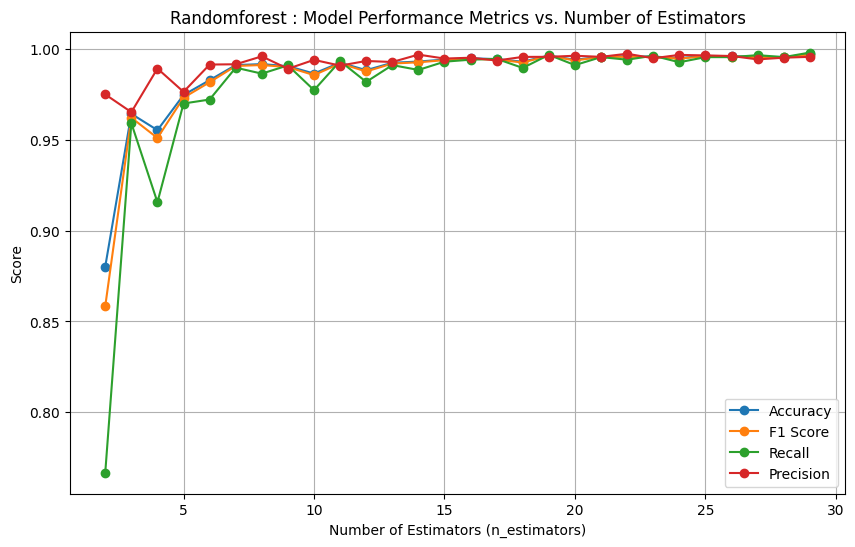

In [ ]:
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
n_estimators_range = range(2, 30)

# Loop through each value of n_estimators
for i in n_estimators_range:
    model = RandomForestClassifier(n_estimators=i, criterion='gini')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Append the metrics to the lists
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, accuracy_scores, label='Accuracy', marker='o')
plt.plot(n_estimators_range, f1_scores, label='F1 Score', marker='o')
plt.plot(n_estimators_range, recall_scores, label='Recall', marker='o')
plt.plot(n_estimators_range, precision_scores, label='Precision', marker='o')

# Labeling
plt.xlabel("Number of Estimators (n_estimators)")
plt.ylabel("Score")
plt.title("Randomforest : Model Performance Metrics vs. Number of Estimators")
plt.legend()
plt.grid(True)
plt.show()

[link text](https://)[link text](https://)# Bagging Classifier[link text](https://)

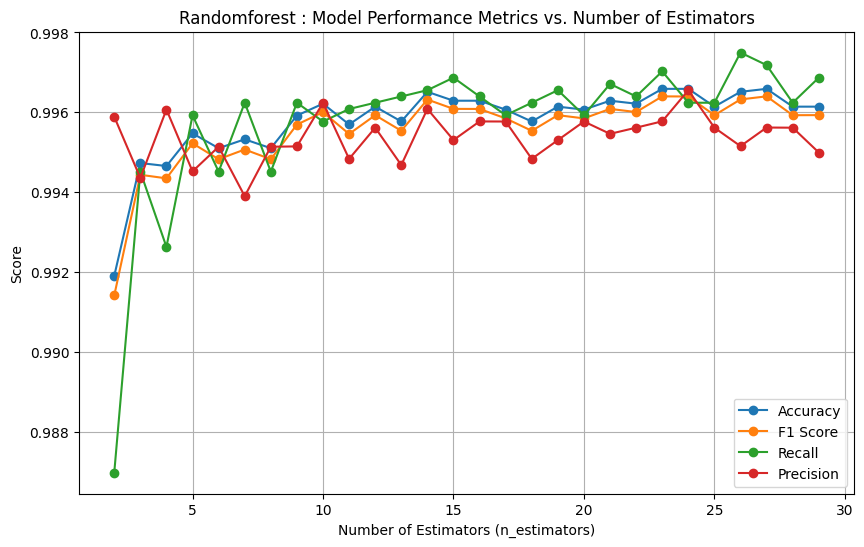

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
n_estimators_range = range(2, 30)

# Loop through each value of n_estimators
for i in n_estimators_range:
    model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Append the metrics to the lists
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, accuracy_scores, label='Accuracy', marker='o')
plt.plot(n_estimators_range, f1_scores, label='F1 Score', marker='o')
plt.plot(n_estimators_range, recall_scores, label='Recall', marker='o')
plt.plot(n_estimators_range, precision_scores, label='Precision', marker='o')

# Labeling
plt.xlabel("Number of Estimators (n_estimators)")
plt.ylabel("Score")
plt.title("Bagging Classifier : Model Performance Metrics vs. Number of Estimators")
plt.legend()
plt.grid(True)
plt.show()



# Extra Trees (Extremely Randomized Trees)

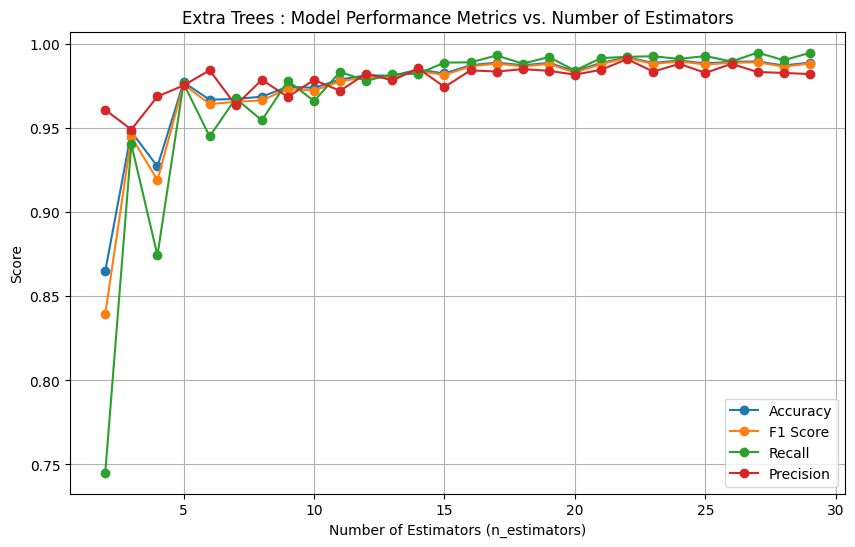

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
n_estimators_range = range(2, 30)

# Loop through each value of n_estimators
for i in n_estimators_range:
    model = ExtraTreesClassifier(n_estimators=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Append the metrics to the lists
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, accuracy_scores, label='Accuracy', marker='o')
plt.plot(n_estimators_range, f1_scores, label='F1 Score', marker='o')
plt.plot(n_estimators_range, recall_scores, label='Recall', marker='o')
plt.plot(n_estimators_range, precision_scores, label='Precision', marker='o')

# Labeling
plt.xlabel("Number of Estimators (n_estimators)")
plt.ylabel("Score")
plt.title("Extra Trees : Model Performance Metrics vs. Number of Estimators")
plt.legend()
plt.grid(True)
plt.show()



# Gradient Boosting Classifier

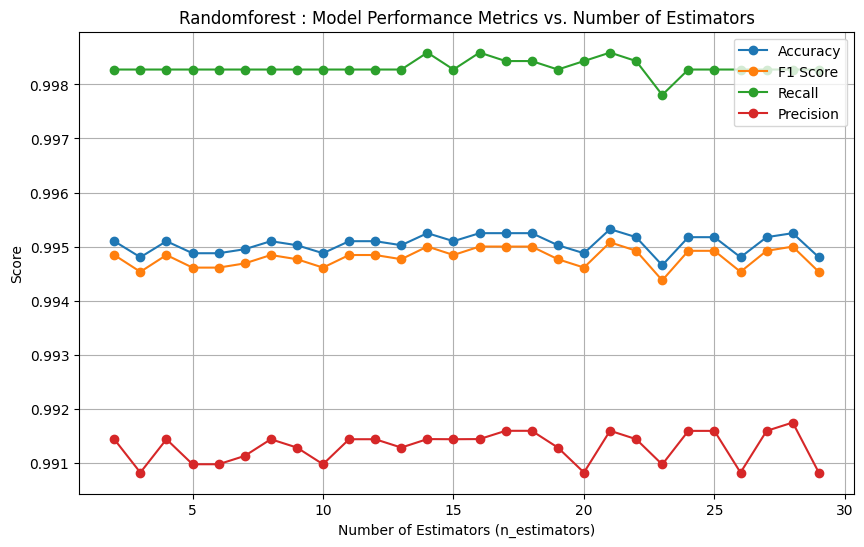

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
n_estimators_range = range(2, 30)

# Loop through each value of n_estimators
for i in n_estimators_range:
    model = GradientBoostingClassifier(n_estimators=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Append the metrics to the lists
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, accuracy_scores, label='Accuracy', marker='o')
plt.plot(n_estimators_range, f1_scores, label='F1 Score', marker='o')
plt.plot(n_estimators_range, recall_scores, label='Recall', marker='o')
plt.plot(n_estimators_range, precision_scores, label='Precision', marker='o')

# Labeling
plt.xlabel("Number of Estimators (n_estimators)")
plt.ylabel("Score")
plt.title("Gradient Boosting Classifier : Model Performance Metrics vs. Number of Estimators")
plt.legend()
plt.grid(True)
plt.show()


#  XGBoost (Extreme Gradient Boosting)

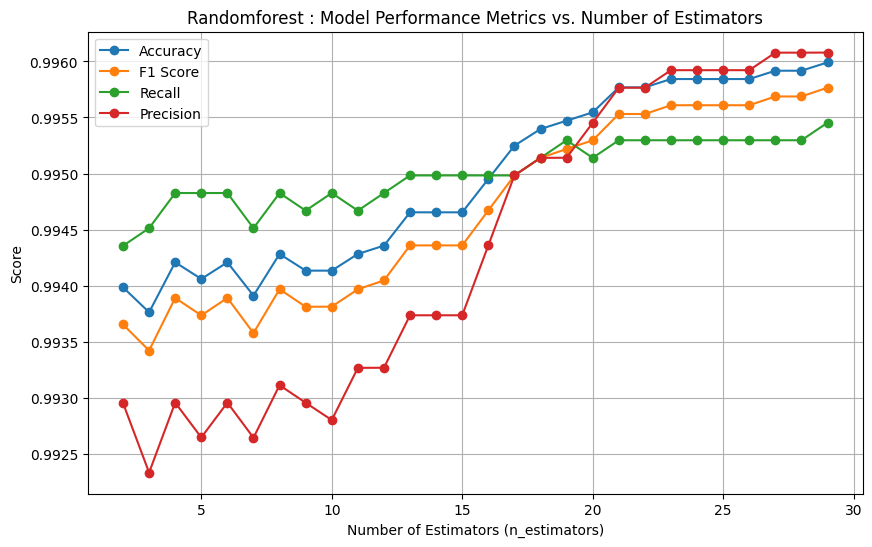

In [ ]:
import xgboost as xgb

accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
n_estimators_range = range(2, 30)

# Loop through each value of n_estimators
for i in n_estimators_range:
    model = xgb.XGBClassifier(n_estimators= i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Append the metrics to the lists
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, accuracy_scores, label='Accuracy', marker='o')
plt.plot(n_estimators_range, f1_scores, label='F1 Score', marker='o')
plt.plot(n_estimators_range, recall_scores, label='Recall', marker='o')
plt.plot(n_estimators_range, precision_scores, label='Precision', marker='o')

# Labeling
plt.xlabel("Number of Estimators (n_estimators)")
plt.ylabel("Score")
plt.title("XGBoost (Extreme Gradient Boosting)t : Model Performance Metrics vs. Number of Estimators")
plt.legend()
plt.grid(True)
plt.show()

# AdaBoost (Adaptive Boosting)

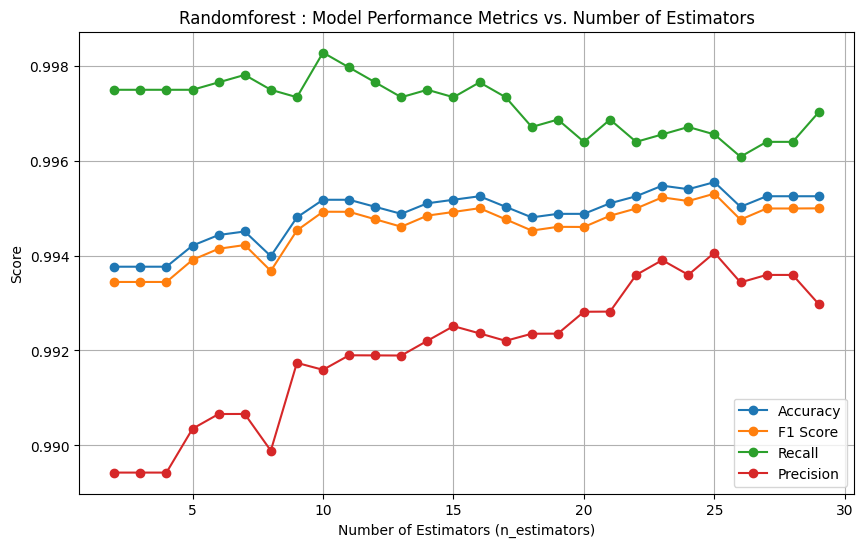

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
n_estimators_range = range(2, 30)

# Loop through each value of n_estimators
for i in n_estimators_range:
    model = AdaBoostClassifier(n_estimators=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Append the metrics to the lists
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, accuracy_scores, label='Accuracy', marker='o')
plt.plot(n_estimators_range, f1_scores, label='F1 Score', marker='o')
plt.plot(n_estimators_range, recall_scores, label='Recall', marker='o')
plt.plot(n_estimators_range, precision_scores, label='Precision', marker='o')

# Labeling
plt.xlabel("Number of Estimators (n_estimators)")
plt.ylabel("Score")
plt.title("AdaBoost (Adaptive Boosting) : Model Performance Metrics vs. Number of Estimators")
plt.legend()
plt.grid(True)
plt.show()

#  LightGBM (Light Gradient Boosting Machine)

[LightGBM] [Info] Number of positive: 15038, number of negative: 16390
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.707282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 724671
[LightGBM] [Info] Number of data points in the train set: 31428, number of used features: 5001
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.478491 -> initscore=-0.086091
[LightGBM] [Info] Start training from score -0.086091
[LightGBM] [Info] Number of positive: 15038, number of negative: 16390
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.987167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 724671
[LightGBM] [Info] Number of data points in the train set: 31428, number of used features: 5001
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.478491 -> initscore=-0.086091
[LightGBM] [Info] Start training from score -0.086091
[Lig

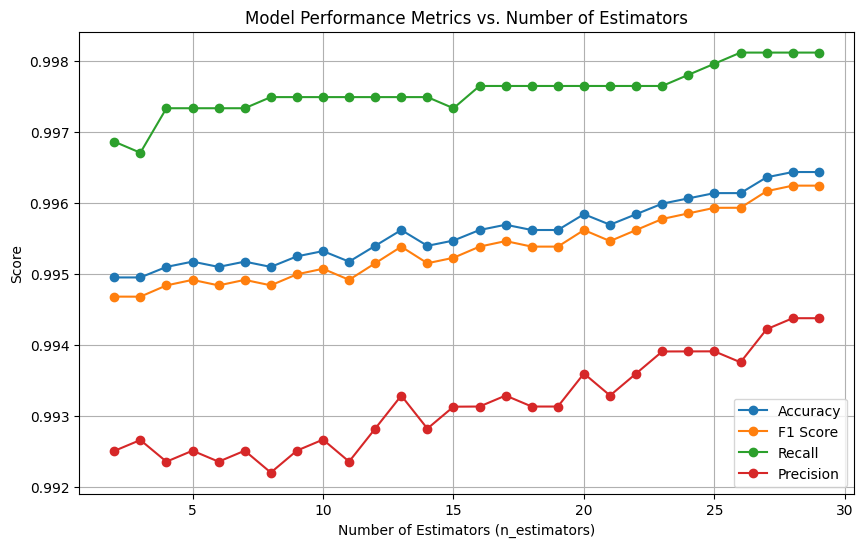

In [ ]:
import lightgbm as lgb

accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
n_estimators_range = range(2, 30)

# Loop through each value of n_estimators
for i in n_estimators_range:
    model = lgb.LGBMClassifier(n_estimators=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Append the metrics to the lists
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, accuracy_scores, label='Accuracy', marker='o')
plt.plot(n_estimators_range, f1_scores, label='F1 Score', marker='o')
plt.plot(n_estimators_range, recall_scores, label='Recall', marker='o')
plt.plot(n_estimators_range, precision_scores, label='Precision', marker='o')

# Labeling
plt.xlabel("Number of Estimators (n_estimators)")
plt.ylabel("Score")
plt.title("LightGBM (Light Gradient Boosting Machine) : Model Performance Metrics vs. Number of Estimators")
plt.legend()
plt.grid(True)
plt.show()


# CatBoost (Categorical Boosting)

Learning rate set to 0.5
0:	learn: 0.1017358	total: 1.18s	remaining: 1.18s
1:	learn: 0.0445378	total: 1.97s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.1017358	total: 1.03s	remaining: 2.06s
1:	learn: 0.0445378	total: 1.82s	remaining: 912ms
2:	learn: 0.0327945	total: 2.62s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.1017358	total: 1.24s	remaining: 3.73s
1:	learn: 0.0445378	total: 2.03s	remaining: 2.03s
2:	learn: 0.0327945	total: 2.84s	remaining: 946ms
3:	learn: 0.0317038	total: 3.45s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.1017358	total: 989ms	remaining: 3.96s
1:	learn: 0.0445378	total: 1.78s	remaining: 2.67s
2:	learn: 0.0327945	total: 2.59s	remaining: 1.72s
3:	learn: 0.0317038	total: 3.21s	remaining: 801ms
4:	learn: 0.0268667	total: 3.92s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.1017358	total: 986ms	remaining: 4.93s
1:	learn: 0.0445378	total: 1.77s	remaining: 3.55s
2:	learn: 0.0327945	total: 2.57s	remaining: 2.57s
3:	learn: 0.0317038	total: 3.19s	

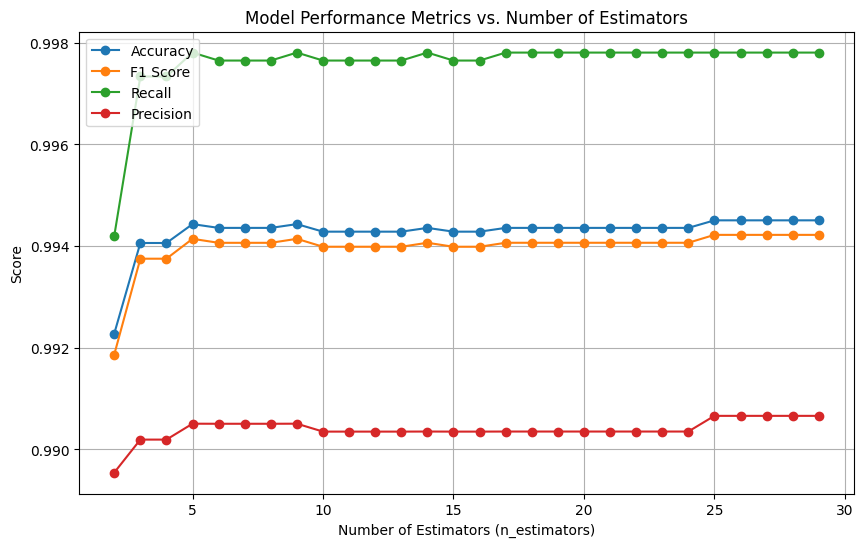

In [ ]:
from catboost import CatBoostClassifier
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
n_estimators_range = range(2, 30)

# Loop through each value of n_estimators
for i in n_estimators_range:
    model = CatBoostClassifier(iterations=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Append the metrics to the lists
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, accuracy_scores, label='Accuracy', marker='o')
plt.plot(n_estimators_range, f1_scores, label='F1 Score', marker='o')
plt.plot(n_estimators_range, recall_scores, label='Recall', marker='o')
plt.plot(n_estimators_range, precision_scores, label='Precision', marker='o')

# Labeling
plt.xlabel("Number of Estimators (n_estimators)")
plt.ylabel("Score")
plt.title("CatBoost (Categorical Boosting) : Model Performance Metrics vs. Number of Estimators")
plt.legend()
plt.grid(True)
plt.show()